# Apply msmbuilder API to WT ff14SB cTN

MD datasets are usually quite large. It doesn't make sense to load everything into memory at once. The `dataset` object lazily-loads trajectories as they are needed. Below, we create a dataset out of all the trajectories we have at the moment.

In [1]:
from msmbuilder.dataset import dataset
import numpy as np
import os
from mdtraj.utils import timing

In [2]:
with timing("Loading data as dataset object"):
    xyz = dataset("/Users/je714/wt_data/run1/05*nc", topology="/Users/je714/wt_data/test.pdb")

Loading data as dataset object: 0.179 seconds


## Featurization
The raw (x, y, z) coordinates from the simulation do not respect the translational and rotational symmetry of our problem. A Featurizer transforms cartesian coordinates into other representations.

### Dihedrals
Here we use the `DihedralFeaturizer` to turn our data into phi and psi dihedral angles.
Observe that the 6812*3-dimensional space is reduced substantially.

In [7]:
from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
if os.path.isfile('/Users/je714/wt_data/diheds_phi-psi.tgz'):
    with timing("Loading dihedrals from file..."):
        diheds = np.loadtxt('/Users/je714/wt_data/diheds_phi-psi.tgz')
else:
    with timing("Featurizing trajectory into dihedrals..."):
        diheds = featurizer.fit_transform(xyz)
        np.savetxt('/Users/je714/wt_data/diheds_phi-psi.gz', np.concatenate(diheds))
print(xyz[0].xyz.shape)
print(diheds[0].shape)

Featurizing trajectory into dihedrals...: 236.846 seconds
(2500, 6812, 3)
(2500, 1664)


### Contact Featurizer
Featurizer based on residue-residue distances

This featurizer transforms a dataset containing MD trajectories into a vector dataset by representing each frame in each of the MD trajectories by a vector of the distances between pairs of amino-acid residues.

The exact method for computing the the distance between two residues is configurable with the `scheme` parameter. In this case we use `"ca"` to determine the distance between two residues as the distance between their alpha carbons.

In [8]:
# from msmbuilder.featurizer import ContactFeaturizer
# featurizer_contact = ContactFeaturizer("all", scheme="ca")
# contacts = featurizer_contact.fit_transform(xyz)
# print(xyz[0].xyz.shape)
# print(contacts[0].shape)

## Intermediate kinetic model: tICA
`tICA` is similar to PCA. Note the reduction to just 4 dimensions.

In [9]:
from msmbuilder.decomposition import tICA
lag = 10
with timing("calculating tICA with lag time %s" % lag):
    tica_model = tICA(lag_time=lag, n_components=4)
    tica_trajs_diheds = tica_model.fit_transform(diheds)

#tica_trajs_contacs = tica_model.fit_transform(contacts)

#tica_model_contacts = contacts.fit_with(tica_model)
#tica_trajs_contacts = contacts.transform_with(tica_model, 'tica_contacts_lag%s/' % lag, fmt='dir-npy')


# tica_trajs = dataset('./ticas_diheds/')
print(diheds[0].shape)
print(tica_trajs_diheds[0].shape)
#print(tica_contacts_diheds[0].shape)

calculating tICA with lag time 10: 2.596 seconds
(2500, 1664)
(2500, 4)


In [10]:
tica_trajs_diheds[1].shape

(2500, 4)

### tICA Heatmap
We can histogram our data projecting along the two first tICS (the two slowest DOFs found by tICA).

In [11]:
for index, traj in enumerate(xyz):
    if index == 0:
        time = np.copy(traj.time) / 1000
    else:
        time = np.append(time, traj.time / 1000)

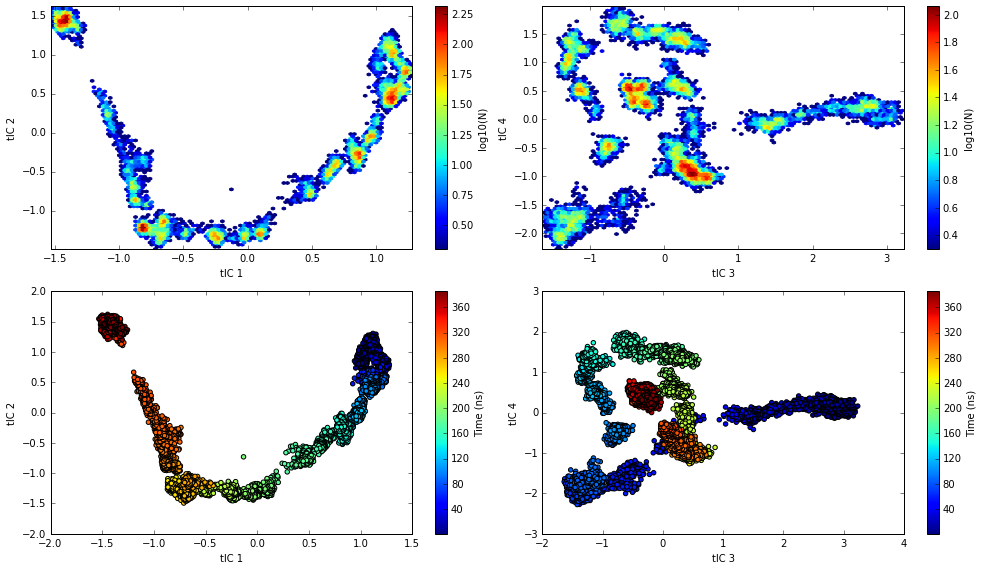

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
txx = np.concatenate(tica_trajs_diheds)

plt.figure(figsize=(14,8))
# plt.grid(False)
plt.subplot(2, 2, 1)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1)
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
cb = plt.colorbar()
cb.set_label('log10(N)')
plt.subplot(2, 2, 2)
plt.hexbin(txx[:,2], txx[:,3], bins='log', mincnt=1)
plt.xlabel('tIC 3')
plt.ylabel('tIC 4')
cb = plt.colorbar()
cb.set_label('log10(N)')
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.scatter(txx[:,0], txx[:,1], c=time)
cbar = plt.colorbar()
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
cbar.set_label('Time (ns)')
plt.subplot(2, 2, 4)
plt.scatter(txx[:,2], txx[:,3], c=time)
cbar = plt.colorbar()
plt.xlabel('tIC 3')
plt.ylabel('tIC 4')
cbar.set_label('Time (ns)')
plt.tight_layout()
plt.savefig('/Users/je714/wt_data/tICA_fromDiheds_API.eps', dpi = 300, format = 'eps')

## Clustering
Conformations need to be clustered into states (sometimes written as microstates). We cluster based on the tICA projections to group conformations that interconvert rapidly. Note that we transform our trajectories from the 4-dimensional tICA space into a 1-dimensional cluster index.

In [13]:
from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=100)
with timing("Custering tica trajs from dihed featurization..."):
    clustered_trajs = clusterer.fit_transform(tica_trajs_diheds)
#clustered_trajs = dataset('./kmeans_diheds_100/')
print(tica_trajs_diheds[0].shape)
print(clustered_trajs[0].shape)

Custering tica trajs from dihed featurization...: 0.445 seconds
(2500, 4)
(2500,)


In [14]:
clusterer.cluster_centers_.shape

(100, 4)

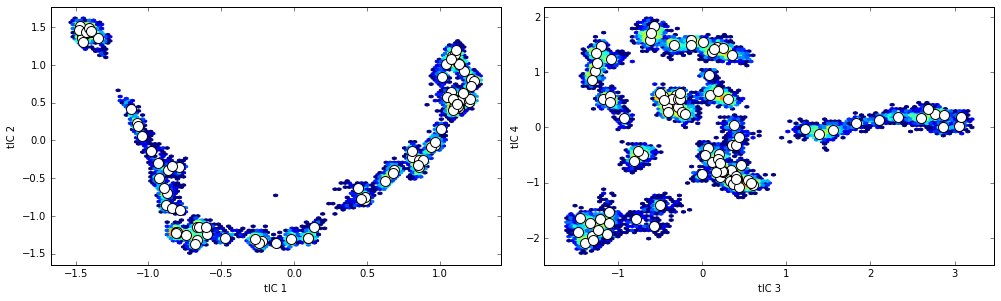

In [17]:
plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1)
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.subplot(2,2,2)
plt.hexbin(txx[:,2], txx[:,3], bins='log', mincnt=1)
plt.scatter(clusterer.cluster_centers_[:,2],
            clusterer.cluster_centers_[:,3], 
            s=100, c='w')
plt.xlabel('tIC 3')
plt.ylabel('tIC 4')
plt.tight_layout()

## MSM
We can construct an MSM from the labeled trajectories.

In [18]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=5)
msm.fit(clustered_trajs)
print("The MSM has %s states.\n" % msm.n_states_)
print(msm.left_eigenvectors_.shape)

MSM contains 11 strongly connected components above weight=0.20. Component 0 selected, with population 17.680707%
The MSM has 13 states.

(13, 13)


In [19]:
print(msm.left_eigenvectors_[:,1].shape)
print(clusterer.cluster_centers_[:,0].shape)

(13,)
(100,)


ValueError: Color array must be two-dimensional

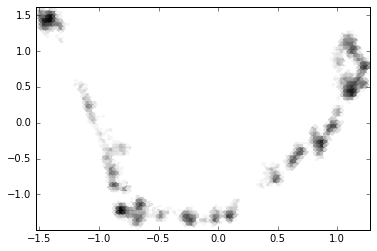

In [20]:
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap="Greys")
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1],
            s=1e4 * msm.populations_, # size by population
            c=msm.left_eigenvectors_[:,1], # color by eigenvector
            cmap="RdBu") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.tight_layout()


## Macrostate model

In [21]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=5)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -4.203374
         Iterations: 12
         Function evaluations: 199


In [22]:
print(msm.left_eigenvectors_[:,1].shape)
print(clusterer.cluster_centers_[:,0].shape)

(13,)
(100,)


ValueError: Color array must be two-dimensional

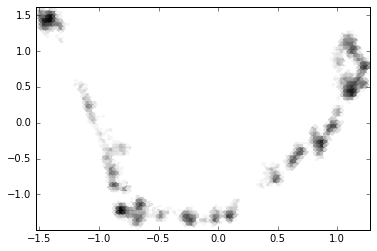

In [23]:
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap="Greys")
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1],
            s=100,
            c=pcca.microstate_mapping_,
      )
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')